In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib widget
# %gui qt

import time
from copy import copy
from tqdm import tqdm
from pathlib import Path
import numpy as np
import numba as nb
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

from vrAnalysis import session
from vrAnalysis import functions
from vrAnalysis import analysis 
from vrAnalysis import helpers
from vrAnalysis import fileManagement as fm
from vrAnalysis import database

# from vrAnalysis.redgui import redCellGUI as rgui

vrdb = database.vrDatabase()

In [6]:
# Immediate next steps for programming work:
# - ROICaT index alignment tools

In [241]:
# Database Requirements: 
# ---------------------
# GUI: db manager
# - show full database -
# - show selected entries (like for example entries with imaging but no suite2p) -
#                --> It would be sweet to make this work where there are some defaults, but then there is also a "filter command" option which you type and goes as the input to the filtering
# - click on entry and do things:
#                --> open file explorer to that session
#                --> do suite2p
#                --> do red cell management
# - update table data? 
# ---------------------
# Operational Commands: 
# - Automatically do suite2p 
# - Check if registration was done before a suite2p update
# - Find way to determine if a suite2p file was updated after the folder was made (indicating that QC was done afterwards) -- so registration should be rerun for imaging data at least
#    -- check if "iscell" is the only thing that was done after registration. In this case, just update the iscell oneData
# ---------------------
# - Add new entry GUI!!!
# ---------------------
# - Check session folders to see if new session is present that isn't registered in the database? 
# ---------------------
# vrExperimentUpdates: 
# -- if edited iscell, will need to re-register the number of ROIs per plane (in "self.values") and reprocess imaging data!
# ---------------------
# vrExperimentRegistration
# -- if error, then note there was an error and append an explanation...!!!
# ---------------------
# I need a readme file for the dbManagement component that shows common uses (e.g. a tutorial)
#    - because otherwise I'll forget what I wrote....
# ---------------------

In [2]:
mouseName = 'CR_Hippocannula6'
dateString = '2022-09-05'
sessionid = '701'
# vrExperiment registration and preprocessing 
# vrReg = vre.vrExperimentRegistration(mouseName, dateString, session, oasis=False, imaging=True)
# vrReg.processTimeline()
# vrReg.processImaging()
# vrReg.processRedCells()
# vrReg.saveParams()
# print(vrReg.sessionPath())
# del vrReg

In [148]:
mouseName = 'ATL012'
dateString = '2023-02-01'
sessionid = '701'

# Load registered vrExperiment
vrexp = session.vrExperiment(mouseName, dateString, sessionid)

In [2]:
mouseName = 'ATL027'
dateString = '2023-08-01'
sessionid = '701'

# Load registered vrExperiment
vrexp = session.vrExperiment(mouseName, dateString, sessionid)

In [ ]:
# # vrExperiment registration and preprocessing 
# vrReg = vre.vrExperimentRegistration(mouseName, dateString, session, oasis=False, imaging=True)
# vrReg.doPreprocessing()
# vrReg.saveParams()
# print(vrReg.sessionPath())
# del vrReg

In session: ATL020/2023-05-04/702, vrFile['rigInfo'] does not exist. Assuming default settings for B2!
Self.value['numTrials'] set by trialInfo.trialIdx>0, but this might not be right. There might be smarter ways to determine which trials are 'good' trials...
frame2time had 2 more than suite2p output. This happens sometimes. I don't like it. I think it's because scanimage sends a TTL before starting the frame
Computing red cell features for ATL020/2023-05-04/702... (usually takes 10-20 seconds)
Facecam preprocessing has not been coded yet!
C:\Users\andrew\Documents\localData\ATL020\2023-05-04\702


In [103]:
# Load registered vrExperiment
vrexp = session.vrExperiment(mouseName, dateString, sessionid)

In [10]:
%%time
speedThreshold = 5
omap, smap, lickmap, distvec = functions.getBehaviorMaps(vrexp,speedThreshold=speedThreshold) # produce smoothed occupancy and speed maps, along with the distance bins used to create them
frameTrialIdx, framePosition, frameSpeed = vrexp.getFrameBehavior() # convert behavioral data into timeframe of spiking data
spkmap = functions.getSpikeMap(vrexp, frameTrialIdx, framePosition, frameSpeed, distvec, omap, speedThreshold=speedThreshold, standardizeSpks=False, doSmoothing=0) # produce the spkmap 
idxFullTrials = np.all(~np.isnan(omap),axis=1) # find out which trials the mouse explored the whole environment
relmse, relcor = functions.measureReliability(spkmap[:,idxFullTrials], numcv=3) # measure reliability of spiking
spInfo = functions.measureSpatialInformation(omap[idxFullTrials], spkmap[:,idxFullTrials]) # measure spatial information of spiking

CPU times: total: 891 ms
Wall time: 542 ms


In [242]:
# Code block for opening redSelectionGUI for a vrExperiment
vrexp = session.vrExperiment(mouseName, dateString, sessionid)
redCell = session.redCellProcessing(vrexp)
# redSelection = rgui.redSelectionGUI(redCell)

In [165]:
scc.vrexp.sessionPrint()

'ATL027/2023-08-01/701'

C:\Users\andrew\miniconda3\envs\vrAnalysis\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\andrew\miniconda3\envs\vrAnalysis\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


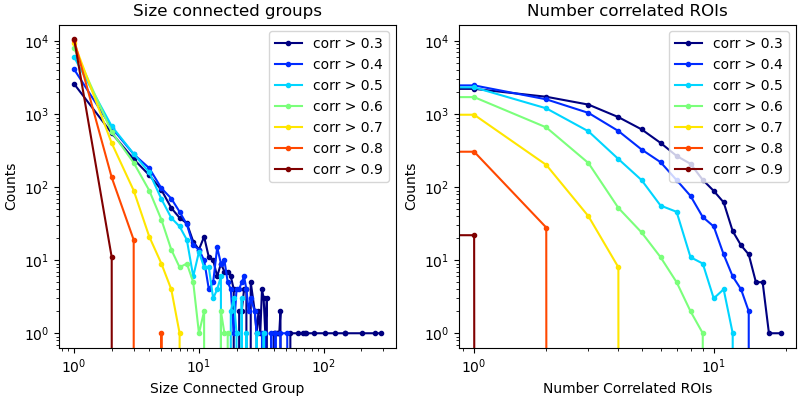

sameCellCandidates is saving a connectionCorrelationStats figure for session: ATL012/2023-01-18/701


AttributeError: 'int' object has no attribute 'num'

In [125]:
# go through each session that has been registered and has imaging data
for ses in vrdb.iterSessions(imaging=True, vrRegistration=True):
    scc = analysis.sameCellCandidates(ses)
    # scc.roiCountHandling(keepPlanes=[1,2,3,4], withSave=True, withShow=False)
    # scc.cdfForThresholds(ylim=None, cdfVals=np.linspace(-0.05,1,121), keepPlanes=[1,2,3,4], distanceCutoff=40, distanceDistant=(50, 250), withSave=True, withShow=False)
    scc.clusterSize(verbose=False, withSave=True, withShow=False)

In [122]:
timestamps = scc.vrexp.loadone('mpci.times')
deconv = scc.vrexp.loadone('mpci.roiActivityDeconvolvedOasis')

corrCutoff = 0.6
distanceCutoff = np.inf
keepPlanes = [1,2,3,4]
boolPlaneOnly = scc.getPairFilter(keepPlanes=keepPlanes)
boolIdx = scc.getPairFilter(corrCutoff=corrCutoff, keepPlanes=keepPlanes, distanceCutoff=distanceCutoff)
pairIdx = np.nonzero(boolIdx)[0]
numPairs = len(pairIdx)

print(f"Percent pairs exceeding corr-cutoff within requested planes: {round(100*sum(boolIdx)/sum(boolPlaneOnly),3)}")

Percent pairs exceeding corr-cutoff within requested planes: 0.099


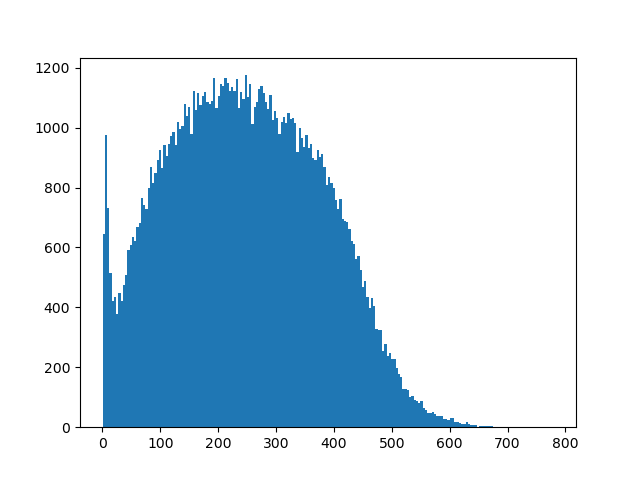

In [123]:
plt.close('all')
plt.hist(scc.pwDist[boolIdx],bins=200)
plt.show()

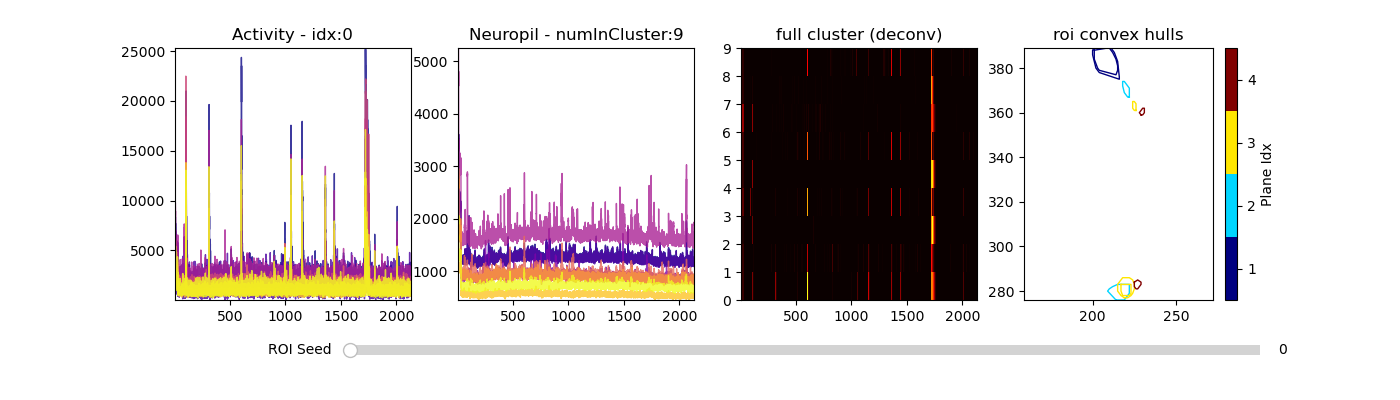

In [75]:
clusterExplorer = analysis.clusterExplorer(scc, corrCutoff=0.5, maxCutoff=None, distanceCutoff=20, minDistance=None, keepPlanes=[1,2,3,4])

Measuring cluster & correlation distribution for cutoff 0.3 : 1/7
Measuring cluster & correlation distribution for cutoff 0.4 : 2/7
Measuring cluster & correlation distribution for cutoff 0.5 : 3/7
Measuring cluster & correlation distribution for cutoff 0.6 : 4/7
Measuring cluster & correlation distribution for cutoff 0.7 : 5/7
Measuring cluster & correlation distribution for cutoff 0.8 : 6/7
Measuring cluster & correlation distribution for cutoff 0.9 : 7/7


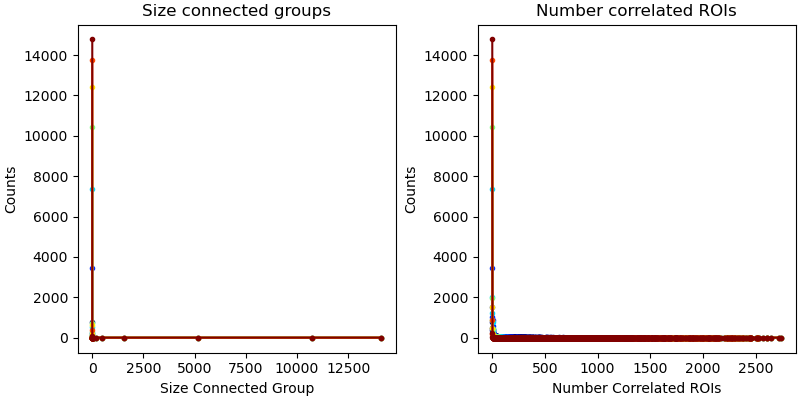

In [115]:
scc.clusterSize()

In [250]:
# okay, looking at these clusters, it seems like there is some serious oversplitting going on in suite2p. That sucks!
# I think I should probably try to rerun some suite2p sessions....
# But for now I'll probably do a "merge" procedure... and I honestly think I'll have to overwrite or add a new "modified" suite2p folder with the stat and ops files

In [3]:
scc = analysis.sameCellCandidates(vrexp)

removeCount_MIS with cutoff: 0.0
removeCount_MIS with cutoff: 0.1
removeCount_MIS with cutoff: 0.2
removeCount_MIS with cutoff: 0.30000000000000004
removeCount_MIS with cutoff: 0.4
removeCount_MIS with cutoff: 0.5
removeCount_MIS with cutoff: 0.6000000000000001
removeCount_MIS with cutoff: 0.7000000000000001
removeCount_MIS with cutoff: 0.8
removeCount_MIS with cutoff: 0.9
removeCount_MIS with cutoff: 1.0


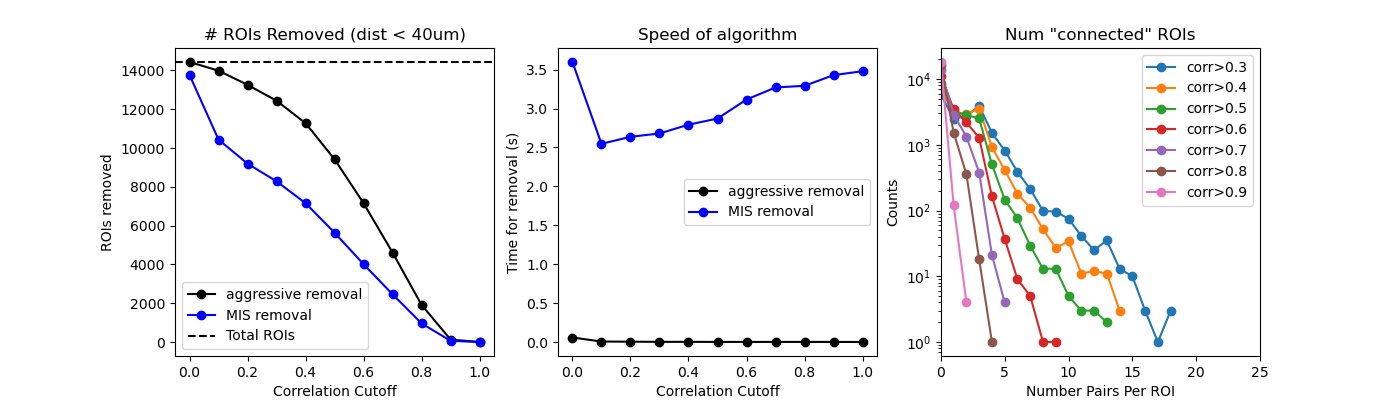

In [403]:
scc.roiCountHandling(keepPlanes=[1,2,3,4], withSave=False, withShow=True)

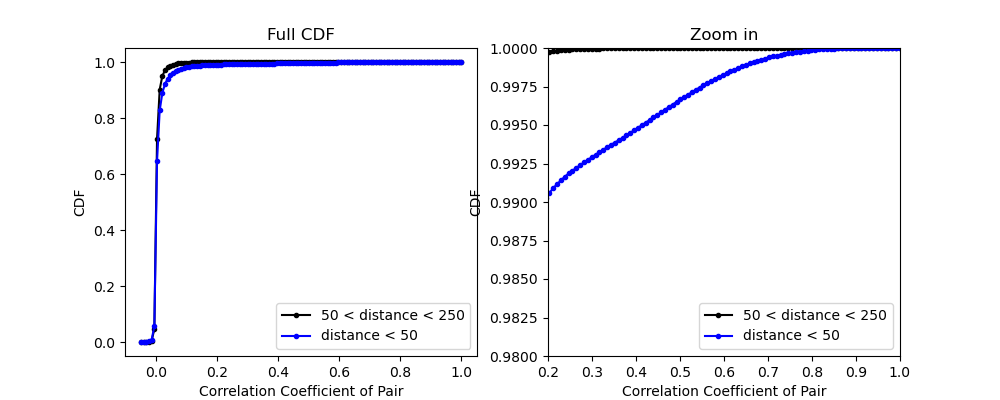

In [251]:
scc.cdfForThresholds(ylim=None, cdfVals=np.linspace(-0.05,1,121), keepPlanes=[1,2,3,4], distanceCutoff=50, distanceDistant=(50, 250));

In [259]:
set(range(10)).difference(set(range(3)))

{3, 4, 5, 6, 7, 8, 9}

In [395]:
import itertools
from copy import copy
import networkx as nx

def bruteApproach(G, maxAttempts=1000):
    assert G.ndim==2 and G.shape[0]==G.shape[1], "G isn't a square"
    assert np.all(G == G.T), "G isn't symmetrical"
    N = G.shape[0]
    assert all([g==0 for g in G[range(N), range(N)]]), "diagonal of G isn't 0"
    vertices = [i for i in range(N)]
    if not(np.any(G)): return vertices
    vperms = itertools.permutations(vertices)
    S = []
    for idx, vp in enumerate(vperms):
        nS = copy(vertices)
        for v in vp:
            nS.remove(v)
            Gc = G[nS][:,nS]
            if not(np.any(Gc)):
                if len(nS)>len(S):
                    S = nS
                break
        if len(S)==N: break
        if maxAttempts is not None and idx>maxAttempts: break
    return S

def greedyApproach(G):
    assert G.ndim==2 and G.shape[0]==G.shape[1], "G isn't a square"
    assert np.all(G == G.T), "G isn't symmetrical"
    N = G.shape[0]
    cG = 1*(G>0)
    numConnections = np.sum(cG,axis=1)
    sortVertByConn = sorted(range(N), key=numConnections.__getitem__)
    
    idxRemove = []
    for sv in sortVertByConn:
        idxRemove.append(sv)
        cG[sv]=0
        cG[:,sv]=0
        if not(np.any(cG)):
            idxKeep = list(set(range(N)).difference(set(idxRemove)))
            return idxKeep
    
    raise ValueError("removed every vertex by G is still connected...")

def getConnectedGroups(G):
    assert G.ndim==2 and G.shape[0]==G.shape[1], "G isn't a square"
    assert np.all(G == G.T), "G isn't symmetrical"
    N = G.shape[0]
    
    cG = 1*(G>0)
    iG = np.arange(N).reshape(1,-1) * cG
    iG[cG==0]=-1
    
    def convert_to_set_representation(iG):
        N = iG.shape[0]
        graph = []
        for n in range(N):
            cidx = iG[n] >= 0
            cconn = iG[n][cidx]
            graph.append(set(cconn))
        return graph
    
    def get_all_connected_groups(graph):
        already_seen = set()
        result = []
        for node in range(len(graph)):
            if node not in already_seen:
                node_group = get_connected_group(graph, node)
                result.append(node_group)
                already_seen = already_seen.union(node_group)
        return result
    
    def get_connected_group(graph, node):
        prevSet = set([node])
        nextSet = prevSet.union(*[graph[n] for n in prevSet])
        while nextSet > prevSet:
            prevSet = copy(nextSet)
            nextSet = prevSet.union(*[graph[n] for n in prevSet])
        return nextSet
    
    graph = convert_to_set_representation(iG)
    components = get_all_connected_groups(graph)
    return [list(c) for c in components]

def stripComponents(G):
    components = getConnectedGroups(G)
    idxKeep = [c[0] for c in components]
    return idxKeep

def misComponents(G):
    def MIS_fromComponent(originalIndex):
        subAM = G[originalIndex][:,originalIndex]
        graph = nx.from_numpy_array(subAM)
        mis = sorted(nx.maximal_independent_set(graph))
        return [originalIndex[m] for m in mis]
    
    components = getConnectedGroups(G)
    mis = [MIS_fromComponent(c) for c in components]
    return sorted(list(set(itertools.chain(*mis))))

def misStraightforward(G):
    graph = nx.from_numpy_array(G)
    mis = nx.maximal_independent_set(graph)
    mis = sorted(mis)
    return mis

10.0
[1 2 0 1 1 3 0 2 4 2]


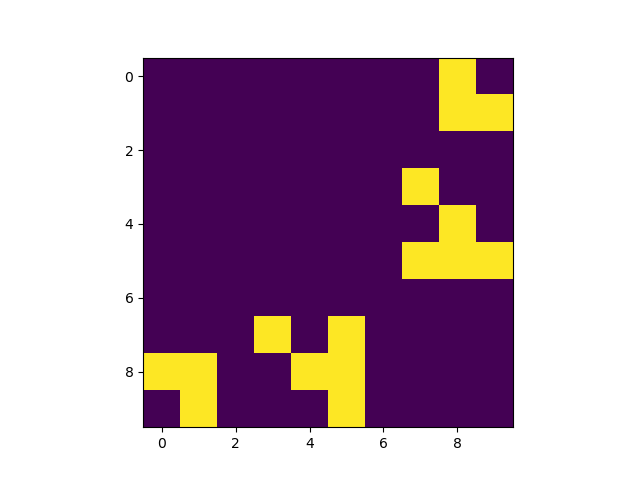

In [380]:
N = 10
NP = int((N**2-N)/2)
print((1 + np.sqrt(1 + 8*NP))/2)

p = 0.1

m = np.random.random(NP)<p
G = sp.spatial.distance.squareform(m)

numConnections = np.sum(G,axis=0)
print(numConnections)

plt.close('all')
plt.imshow(G);
plt.show()


misStrait (2382, 2382) 2382 check: True 0.3


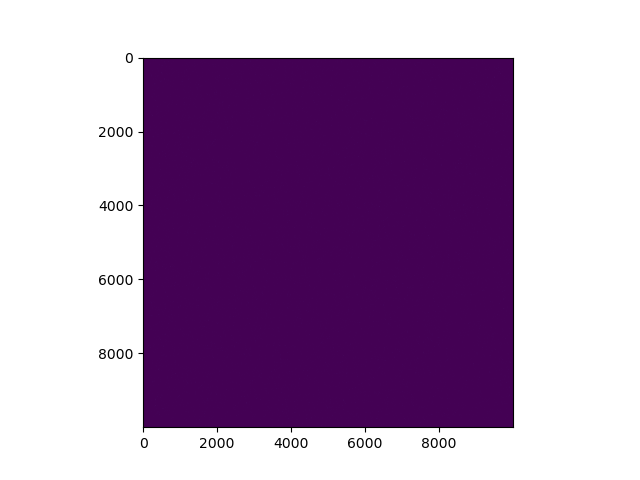

In [396]:
N = 10000
NP = int((N**2-N)/2)

p = 0.001

m = np.random.random(NP)<p
G = sp.spatial.distance.squareform(m)

# t = time.time()
# greedyIndex = greedyApproach(G)
# greedyTime = time.time() - t
# greedyGraph = G[greedyIndex][:,greedyIndex]
# print("greedy", greedyGraph.shape, len(greedyIndex), "check:", not(np.any(greedyGraph)), round(greedyTime,1))

# t = time.time()
# setIndex = stripComponents(G)
# setTime = time.time() - t
# setGraph = G[setIndex][:,setIndex]
# print("set", setGraph.shape, len(setIndex), "check:", not(np.any(setGraph)), round(setTime,1))

# t = time.time()
# bruteIndex = bruteApproach(G, maxAttempts=10000)
# bruteTime = time.time() - t
# bruteGraph = G[bruteIndex][:,bruteIndex]
# print("brute", bruteGraph.shape, len(bruteIndex), "check:", not(np.any(bruteGraph)), round(bruteTime, 1))

t = time.time()
misIndex = misStraightforward(G)
misTime = time.time() - t
misGraph = G[misIndex][:,misIndex]
print("misStrait", misGraph.shape, len(misIndex), "check:", not(np.any(misGraph)), round(misTime, 1))

# t = time.time()
# misIndex = misComponents(G)
# misTime = time.time() - t
# misGraph = G[misIndex][:,misIndex]
# print("misComponents", misGraph.shape, len(misIndex), "check:", not(np.any(misGraph)), round(misTime, 1))



plt.close('all')
plt.imshow(G);
plt.show()

In [397]:
misIndex[:100]

[1,
 13,
 21,
 26,
 29,
 31,
 37,
 39,
 45,
 49,
 50,
 51,
 57,
 58,
 66,
 67,
 68,
 73,
 76,
 79,
 81,
 85,
 87,
 88,
 93,
 104,
 105,
 107,
 109,
 111,
 114,
 118,
 119,
 127,
 128,
 129,
 132,
 134,
 148,
 149,
 156,
 157,
 184,
 187,
 188,
 194,
 200,
 202,
 203,
 207,
 208,
 209,
 210,
 212,
 217,
 232,
 238,
 241,
 244,
 252,
 265,
 269,
 272,
 273,
 283,
 284,
 286,
 287,
 294,
 299,
 305,
 306,
 318,
 322,
 326,
 327,
 328,
 331,
 333,
 335,
 341,
 347,
 349,
 350,
 351,
 361,
 371,
 375,
 378,
 380,
 383,
 391,
 400,
 404,
 407,
 413,
 414,
 415,
 420,
 427]

In [351]:
bruteIndex

[43, 45, 46, 47, 48, 49]

In [352]:
setIndex

[0]

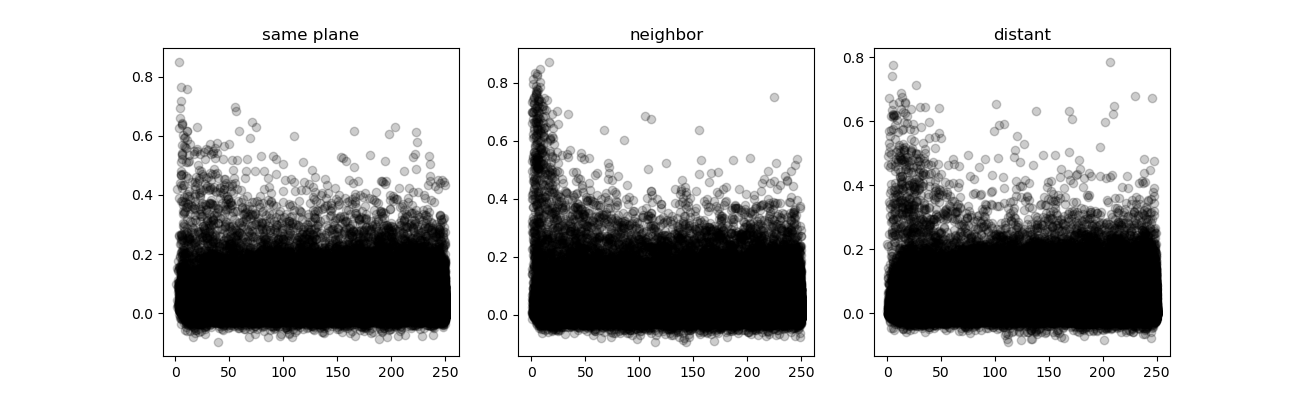

In [39]:
scc.scatterForThresholds(keepPlanes=[1,2,3,4], distanceCutoff=250);

In [40]:
# okay, these plots suck to make (slow) and are pretty rough, anyway. How about this: 
# 1: define a "far enough away" criterion for pairs you _know_ are not the same ROI 
# 2: make a distribution plot of the correlations at that distance
# 3: then, for each plane relationship category (same, neighbor, far away), plot the relationship between x-y distance and correlation (only for close potential same cell pairs)
# 4: additionally, for potential same cell pairs, plot the relationship between the size of the two ROIs in the pair
# 5: probably save an index of ROIs to kill in one-data and also save the parameters used for removing it (e.g. the thresholds for deciding it's the same cell).

# if possible, assign a x-y-piezo position to each sample of the imaging data and condition correlation analysis on the laser actually pointing to the same place

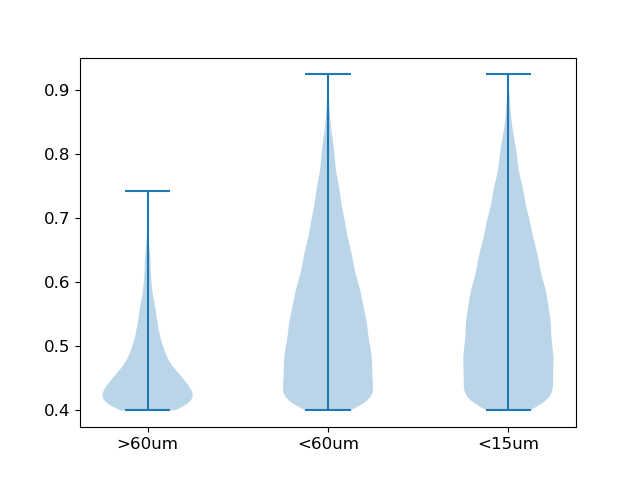

In [282]:
corrCutoff = 0.4

pairIdx = scc.getPairFilter(corrCutoff=corrCutoff, distanceCutoff=320)
pairIdx &= scc.pwDist >= 60

closeIdx = scc.getPairFilter(corrCutoff=corrCutoff, distanceCutoff=60)
veryCloseIdx = scc.getPairFilter(corrCutoff=corrCutoff, distanceCutoff=15)

plt.close('all')
fig = plt.figure()
plt.violinplot(dataset=[scc.xcROIs[pairIdx], scc.xcROIs[closeIdx], scc.xcROIs[veryCloseIdx]], positions=[0, 1, 2])
plt.xticks(range(3), labels=['>60um', '<60um', '<15um'])    
plt.show();

99999it [00:37, 2668.16it/s]


13.887700080871582 10.183363914489746 9.959231853485107


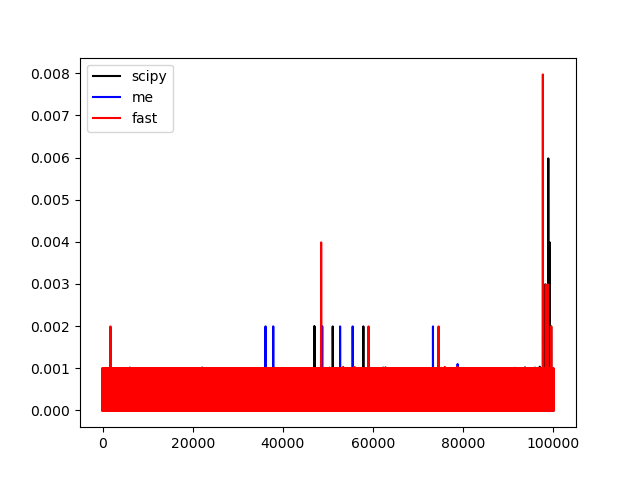

In [189]:
n = 10
p = int(N*(N-1)/2)
s = (p,)

def checkScipy(s):    
    d = int(np.ceil(np.sqrt(s[0] * 2)))

    # Check that v is of valid dimensions.
    if d * (d - 1) != s[0] * 2:
        return False
        #raise ValueError('Incompatible vector size. It must be a binomial '
        #                 'coefficient n choose 2 for some integer n >= 2.')
    return True

def checkMine(s):
    d = (1 + np.sqrt(1+8*s[0]))/2
    if d != int(d):
        return False
        #raise ValueError('incompatible vector size, not coefficient n choose 2')
    return True

def checkFast(s):
    d = (1 + np.sqrt(1+8*s[0]))/2
    if not(d.is_integer()):
        return False
        #raise ValueError('incompatible vector size, not coefficient n choose 2')
    return True

nRange = range(1,100000)
numRng = len(nRange)
nRepeats = 100
spTime = [0.]*numRng
mnTime = [0.]*numRng
fsTime = [0.]*numRng
for i,n in tqdm(enumerate(nRange)):
    s = (n,)
    #s = (int(n*(n-1)/2),)
    for _ in range(nRepeats):
        t = time.time()
        vs = checkScipy(s)
        spTime[i] += time.time() - t
        
        t = time.time()
        vm = checkMine(s)
        mnTime[i] += time.time() - t
        
        t = time.time()
        vf = checkFast(s)
        fsTime[i] += time.time() - t
        
        assert vs == vm == vf, f"not all identical, {s}"
        #assert vs and vm and vf, f"not all true, {s}"
        
print(sum(spTime), sum(mnTime), sum(fsTime))

plt.close('all')
plt.plot(nRange, spTime, c='k', label='scipy')
plt.plot(nRange, mnTime, c='b', label='me')
plt.plot(nRange, fsTime, c='r', label='fast')
plt.legend()
plt.show()
#%timeit checkScipy(s)
#%timeit checkMine(s)

In [187]:
checkFast(s)

True

In [184]:
getD((2,))

2.5615528128088303

In [171]:
def getD(s):
    return (1 + np.sqrt(1+8*s[0]))/2

In [172]:
d = getD(s)

In [173]:
d

5.0